<a href="https://colab.research.google.com/github/Mohd6288/DAMLCP_Project/blob/main/06_pix2pix_2_visualizing_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing the Pix2Pix results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/models/pix2pix_facades /content/models


Let's visualize some random results from the Pix2Pix model. To do so we just need to load a generator model and feed it with a "source image". Here you will need to provide an image that is compatible with the source you trained on. We will test some of the pre-trained models we provide you with. One transforming face landmarks into Rembrandt paintings, and one transforming face edges into comics drawings.

This code expects the following directory structure:
```bash
 models
 └── pix2pix_model_name
      ├── model.1.pt
      └── model.2.pt
```

You can find some [pre-trained models here](https://drive.google.com/drive/folders/19_Xfy10yOy1FCOu9Dn_ihiGct4oN0y__?usp=sharing), that are ready to be tested! Some of them have been trained by me, others by Irini and Daniel of [DMLAP](https://github.com/IriniKlz/DMLAP-2024/tree/main) (If you click on the top folder "models", you can download them all in one go.)

In [ ]:
import os
import pathlib
import numpy as np

import torch

import torchvision as tv
from torchvision.transforms import v2

import cv2
from skimage import io
from skimage import feature

import matplotlib
import matplotlib.pyplot as plt

# Get cpu, gpu or mps device for training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
# fixed directory structure -------------
DATASETS_DIR = pathlib.Path("datasets")
DATASETS_DIR.mkdir(exist_ok=True)

MODELS_DIR = pathlib.Path("models")
MODELS_DIR.mkdir(exist_ok=True)

GENERATED_DIR = pathlib.Path("generated")
GENERATED_DIR.mkdir(exist_ok=True)
# ----------------------------------------

## Utils

In [ ]:
def generate(model, image):
    image = v2.ToImage()(image)

    # Check for grayscale (single channel) or with alpha (four) (with GPT 4o)
    if image.shape[0] == 1:
        image = image.repeat(3, 1, 1)  # Convert grayscale to RGB by repeating the channel 3 times
    elif image.shape[0] == 4:
        image = image[:3, :, :]  # Remove the alpha channel by taking the first 3 channels (RGB)

    image = v2.Resize((256,256), antialias=True)(image)
    image = v2.ToDtype(torch.float32, scale=True)(image) # from [0,255] to [0,1]
    image = image.to(device)
    image = image[None, ...] # add a batch dimension
    with torch.no_grad():
        outputs = model(image).detach().cpu()
    output = outputs[0].permute(1, 2, 0) * 0.5 + 0.5
    return output.numpy()

In [ ]:
def apply_bw_cv2(img):
    """Turn an image black and white using OpenCV"""
    grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return cv2.merge([grey_img, grey_img, grey_img]) # Force three channels for shape compat, thanks ChatGPT!

def apply_canny_cv2(img, thresh1=160, thresh2=250, invert=False):
    """Apply the OpenCV Canny edge detector to an image"""
    grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(grey_img, thresh1, thresh2)
    if invert:
        edges = cv2.bitwise_not(edges)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

def apply_canny_skimage(img, sigma=1.5, invert=False):
    """Apply the Scikit-Image Canny edge detector to an image"""
    grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = (feature.canny(grey_img, sigma=sigma)*255).astype(np.uint8)
    if invert:
        edges = cv2.bitwise_not(edges)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

In [ ]:
def load_model(models_dir, chosen_dir, chosen_model):
    # check available directories
    dnames = [d for d in models_dir.iterdir() if d.is_dir()]

    print("Available directories:")
    for i, d in enumerate(dnames):
        print(f"{i} | {d}")
    print()

    # choose your directory
    d_id = chosen_dir

    if d_id < 0 or d_id > len(dnames) - 1:
        print(f"!!Directory index ({chosen_dir}) invalid!!")
        return None

    chosen_dir = dnames[d_id]

    print("Chosen directory:")
    print(f"{d_id} | {chosen_dir}")
    print("---")

    # check available models
    fnames = list(chosen_dir.glob("*.pt"))

    if fnames:
        print("Available models:")
        for i, f in enumerate(fnames):
            print(f"{i} | {f.name}")
        print()

        m_id = chosen_model

        if m_id < 0 or m_id > len(fnames) - 1:
            print(f"!!Directory index ({chosen_model}) invalid!!")
            return None

        chosen_model = fnames[m_id]

        print("Chosen model:")
        print(f"{m_id} | {chosen_model.name}")
        print("---")

        return torch.jit.load(chosen_model,map_location=device)

    else:
        print(f"No model found in {chosen_dir}")
        print("---")

def display_transform(model, img_path, transform=None):

    img = io.imread(img_path)

    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.title('Input image')
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 3, 2)

    # if we pass a transformation, preprocess the source image
    if transform:
        img = transform(img) # try apply_canny_cv2 & possible to play with channels
        plt.title('Processed input')
        plt.imshow(img)
        plt.axis('off')
        plt.subplot(1, 3, 3)

    img = generate(model, img)
    plt.title('Generated image')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## Automated model loading & checking

Available directories:
0 | models/pix2pix_face2comics
1 | models/pix2pix_cityscapes
2 | models/.ipynb_checkpoints

Chosen directory:
1 | models/pix2pix_cityscapes
---
Available models:
0 | pix2pix_cityscapes.iter_23496.pt

Chosen model:
0 | pix2pix_cityscapes.iter_23496.pt
---


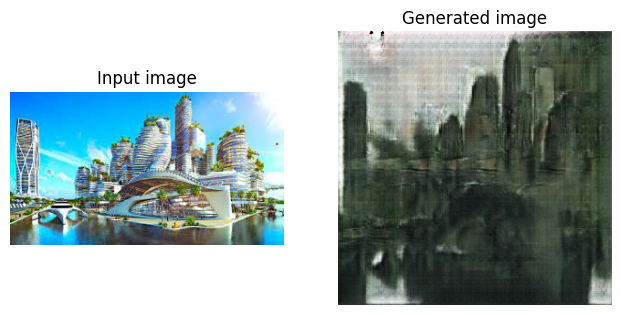

In [ ]:
model = load_model(MODELS_DIR, 1, 0)

display_transform(model, "ne.jpeg", transform=None)

Available directories:
0 | models/pix2pix_face2comics
1 | models/.ipynb_checkpoints

Chosen directory:
0 | models/pix2pix_face2comics
---
Available models:
0 | pix2pix_face2comics.iter_45000_scripted.pt
1 | pix2pix_face2comics.iter_45000.pt

Chosen model:
0 | pix2pix_face2comics.iter_45000_scripted.pt
---


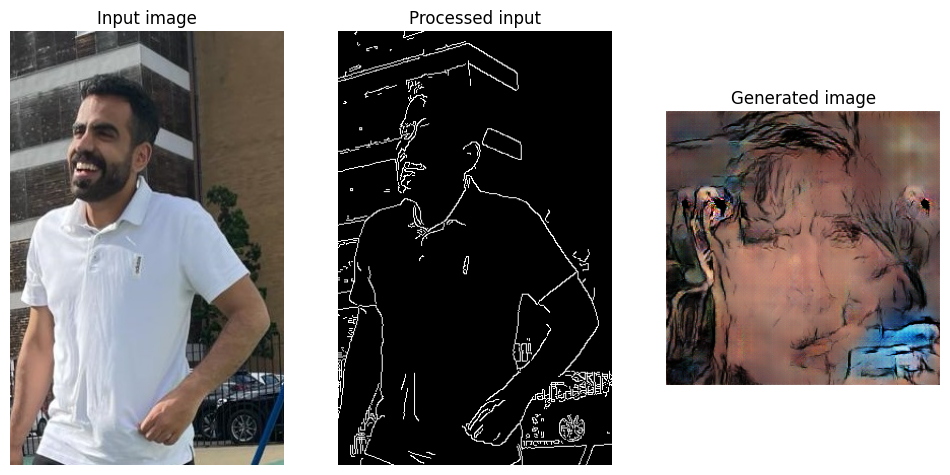

In [ ]:
model = load_model(MODELS_DIR, 0, 0)

if model:
    display_transform(model, "me.jpeg", transform=apply_canny_cv2)

Available directories:
0 | models/pix2pix_face2comics
1 | models/pix2pix_cityscapes
2 | models/.ipynb_checkpoints
3 | models/pix2pix_edge2comics

Chosen directory:
3 | models/pix2pix_edge2comics
---
Available models:
0 | edge2comics_60_generator_scripted.pt
1 | pix2pix_edge2comics.iter_16583_scripted.pt

Chosen model:
1 | pix2pix_edge2comics.iter_16583_scripted.pt
---


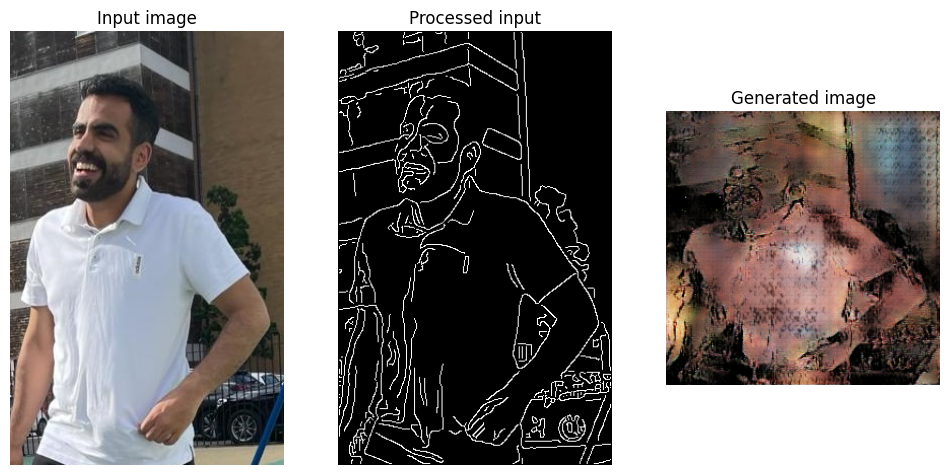

In [ ]:
model = load_model(MODELS_DIR, 3, 1)

if model:
    display_transform(model, "me.jpeg", transform=apply_canny_skimage)

Available directories:
0 | models/pix2pix_facebw2color
1 | models/pix2pix_face2comics
2 | models/pix2pix_cityscapes
3 | models/.ipynb_checkpoints
4 | models/pix2pix_edge2comics

Chosen directory:
0 | models/pix2pix_facebw2color
---
Available models:
0 | pix2pix_facebw2color.iter_18000.pt

Chosen model:
0 | pix2pix_facebw2color.iter_18000.pt
---


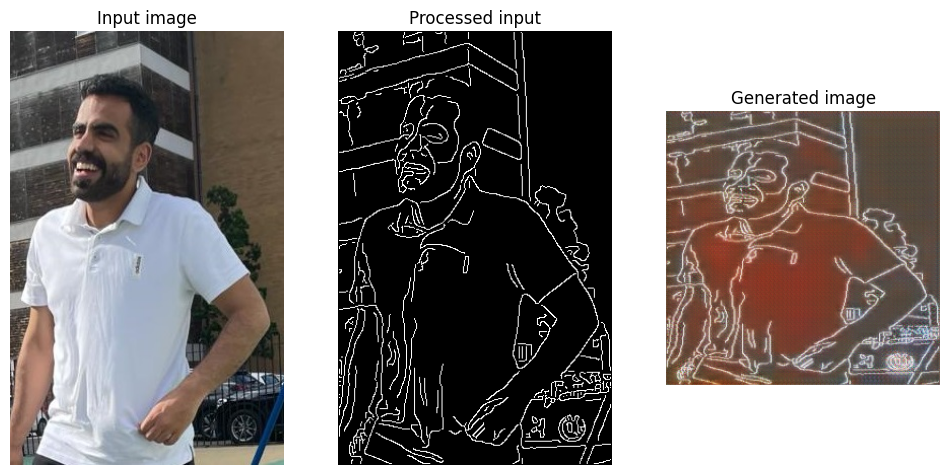

In [ ]:
model = load_model(MODELS_DIR, 0, 0)

if model:
    display_transform(model, "me.jpeg", transform=apply_canny_skimage)

Available directories:
0 | models/pix2pix_facebw2color
1 | models/pix2pix_face2comics
2 | models/pix2pix_cityscapes
3 | models/pix2pix_facades
4 | models/.ipynb_checkpoints
5 | models/pix2pix_edge2comics

Chosen directory:
3 | models/pix2pix_facades
---
Available models:
0 | pix2pix_facades.iter_8000_scripted.pt

Chosen model:
0 | pix2pix_facades.iter_8000_scripted.pt
---


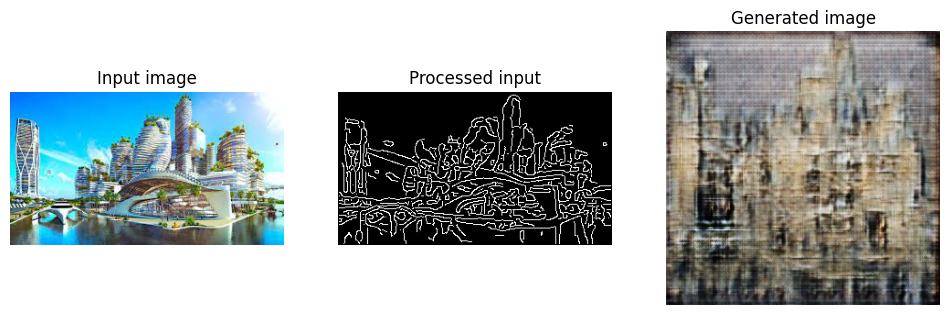

In [ ]:
model = load_model(MODELS_DIR, 3, 0)

if model:
    display_transform(model, "ne.jpeg", transform=apply_canny_skimage)

---

## Facades

Let's try now with the "facade" dataset (one of the official pix2pix datasets).

Let's load the model for a given epoch as usual:

In [ ]:
MODEL_NAME = "facades"
PIX2PIX_DIR = MODELS_DIR / f"pix2pix_{MODEL_NAME}"

# check available models
fnames = list(PIX2PIX_DIR.glob("*.pt"))

for i, f in enumerate(fnames):
    print(f"{i} | {f}")

if fnames:
    ID = 0 # change me!

    print()
    print(f"Loading:")
    print(f"{ID} | {fnames[ID]}")
    model = torch.jit.load(fnames[ID],map_location=device)
else:
    print(f"No model found in {PIX2PIX_DIR}")

0 | models/pix2pix_facades/pix2pix_facades.iter_8000_scripted.pt

Loading:
0 | models/pix2pix_facades/pix2pix_facades.iter_8000_scripted.pt


The color map for the facades is based on the ["jet" color map](https://matplotlib.org/stable/tutorials/colors/colormaps.html), which maps continuous values between 0 and 1 to a color palette. See [this document](https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_2013.pdf) for details on what each color means. Matplotlib gives us easy access to these colors

In [ ]:
def jet_color(v):
    c = matplotlib.colormaps.get_cmap('jet')
    return np.array(c(v)) * 255 # The output of this function is between 0 and 1, we will use 0 to 255 colors

Here we will use the Canvas API directly to generate some random rectangles filled with colors from the palette. The labels are (should be) organized as follows:  

0. background
1. facade
2. window
3. door
4. cornice
5. sill
6. balcony
7. blind
8. deco
9. molding
10. pillar
11. shop

In [ ]:
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu10).
libjpeg-dev set to manually installed.
libgif-dev is already the newest version (5.1.9-2ubuntu0.1).
libgif-dev set to manually installed.
The following additional packages will be installed:
  libblkid-dev libblkid1 libcairo-script-interpreter2 libffi-dev libglib2.0-dev libglib2.0-dev-bin
  libice-dev liblzo2-2 libmount-dev libmount1 libpixman-1-dev libselinux1-dev libsepol-dev
  libsm-dev libxcb-render0-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc libgdk-pixbuf2.0-bin | libgdk-pixbuf2.0-dev
  libxml2-utils libice-doc cryptsetup-bin libsm-doc
The following NEW packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libcairo2-dev libffi-dev libglib2.0-dev
  libglib2.0-dev-bin libice-dev liblzo2-2 libmount-dev libpixman-1-dev libselinux1-dev libsepol-dev
  libsm-dev libxc

In [ ]:
!curl -O https://raw.githubusercontent.com/jchwenger/DMLCP/main/python/canvas.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42441  100 42441    0     0  82171      0 --:--:-- --:--:-- --:--:-- 82090


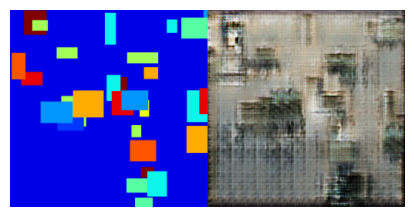

In [ ]:
import canvas

# this gives us values between 0 and 1 for the labels
labels = np.linspace(0, 1, 12)

def random_label():
    #return labels[np.random.choice([2, 3, 6, 8, 10])] # place here the labels you want to randomly choose from
    return np.random.choice(labels[2:]) # simply excludes background and facade
    #return np.random.uniform(0.1, 1.0)
c = canvas.Canvas(512, 256)
c.background(jet_color(0)[:-1]) # Fill with the darkest color (background)
c.no_stroke()

# Draw the main facade
pad = 0
c.fill(jet_color(labels[1]))
c.rect(pad, pad, 256-pad*2, 256)

# Draw some random rectangle with random feature colors
for i in range(30):
    c.fill(jet_color(random_label()))
    c.rect(np.random.uniform(pad, c.height-pad*2, size=2), np.random.uniform(2, 7, size=2)*6)
    #c.fill(jet_color(random_label()))
    #c.circle(np.random.uniform(pad, c.height-pad, size=2), np.random.uniform(5, c.height*0.15)*0.5) #, size=2))
# Get the left half of the canvas image
img = c.get_image()[:, :256]

# And transform it using our pix2pix model
result = generate(model, img.copy())
c.image(result, [256, 0])
c.show()